In [1]:
# Cell 1
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import io
import os
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import random
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model
from keras.utils import custom_object_scope
from tensorflow.keras.layers import Bidirectional, SimpleRNN, Dense

In [9]:
# Cell 2
# Updated function
# Updated function without saving data inside
def upload_and_process_files(directory, num_files_to_use=None):
    svc_files = [f for f in os.listdir(directory) if f.endswith('.svc')]
    
    # If num_files_to_use is specified, only take that many files sequentially
    if num_files_to_use:
        svc_files = svc_files[:num_files_to_use]  # Take the first num_files_to_use files

    data_frames = []  # Processed data after scaling
    original_data_frames = []  # Save the original unscaled data
    scalers = []
    input_filenames = []  # List to store input filenames

    num_files = len(svc_files)
    
    # Commented out the figure and subplots for displaying files
    # fig, axs = plt.subplots(1, num_files, figsize=(6*num_files, 6), constrained_layout=True)
    # if num_files == 1:
    #     axs = [axs]

    for i, filename in enumerate(svc_files):
        file_path = os.path.join(directory, filename)
        input_filenames.append(filename)  # Store the filename
        df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
        df.columns = ['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude']
        
        # Modify timestamp to start from 0
        df['timestamp'] = (df['timestamp'] - df['timestamp'].min()).round().astype(int)
        
        # Keep a copy of the original data before scaling
        original_data_frames.append(df.copy())  # Save the original unmodified data
        
        # Process the data for use in the model
        df = df.iloc[:, [0, 1, 2, 3, 4, 5, 6]] 
        data_frames.append(df)
        scaler = MinMaxScaler()
        normalized_data = scaler.fit_transform(df[['x', 'y', 'timestamp']])
        scalers.append(scaler)

        # Commented out plotting of 'on_paper' and 'in_air' points
        # on_paper = df[df['pen_status'] == 1]
        # in_air = df[df['pen_status'] == 0]
        # axs[i].scatter(-on_paper['y'], on_paper['x'], c='blue', s=1, alpha=0.7, label='On Paper')
        # axs[i].scatter(-in_air['y'], in_air['x'], c='red', s=1, alpha=0.7, label='In Air')
        # axs[i].set_title(f'Original Data {i + 1}')
        # axs[i].set_xlabel('-y')
        # axs[i].set_ylabel('x')
        # axs[i].legend()
        # axs[i].set_aspect('equal')

    # Commented out the display of the figure
    # plt.show()

    processed_data = [np.column_stack((scaler.transform(df[['x', 'y', 'timestamp']]), df['pen_status'].values)) 
                      for df, scaler in zip(data_frames, scalers)]
    avg_data_points = int(np.mean([df.shape[0] for df in data_frames]))

    return data_frames, processed_data, scalers, avg_data_points, input_filenames, original_data_frames  # Return original data

# Save data outside the function
def save_original_data(data_frames, input_filenames, output_folder='original_absolute'):
    os.makedirs(output_folder, exist_ok=True)
    for df, filename in zip(data_frames, input_filenames):
        save_path = os.path.join(output_folder, filename)
        df.to_csv(save_path, sep=' ', index=False, header=False)

directory = '1-7-minus3'  # Directory where the .svc files are stored
num_files_to_use = 504
data_frames, processed_data, scalers, avg_data_points, input_filenames, original_data_frames = upload_and_process_files(directory, num_files_to_use)

# Save the original data after processing
save_original_data(original_data_frames, input_filenames)

# Store the name of the first file for use in Cell 4
input_filename = input_filenames[0] if input_filenames else 'processed_data'
print(f"Number of processed files: {len(processed_data)}")
print(f"Average number of data points: {avg_data_points}")


C:\Users\annek\AppData\Local\Temp\ipykernel_9012\3539305864.py:26: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
C:\Users\annek\AppData\Local\Temp\ipykernel_9012\3539305864.py:26: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
C:\Users\annek\AppData\Local\Temp\ipykernel_9012\3539305864.py:26: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
C:\Users\annek\AppData\Local\Temp\ipykernel_9012\3539305864.py:26: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecat

Number of processed files: 504
Average number of data points: 2948


In [10]:
# Cell 6 (modified)
# Modified VRNN class with additional features from second implementation
class VRNN(tf.keras.Model):
    def __init__(self, latent_dim, hidden_dim=128, sequence_length=1, **kwargs):
        super(VRNN, self).__init__(**kwargs)
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.sequence_length = sequence_length

        # Original layers
        self.rnn = tf.keras.layers.GRU(hidden_dim, return_sequences=True, return_state=True)
        
        # Encoder layers
        self.encoder_dense1 = tf.keras.layers.Dense(128, activation='relu')
        self.encoder_dense2 = tf.keras.layers.Dense(64, activation='relu')
        self.encoder_dense3 = tf.keras.layers.Dense(32, activation='relu')
        self.encoder_dense4 = tf.keras.layers.Dense(latent_dim * 2)

        # Decoder layers
        self.decoder_dense1 = tf.keras.layers.Dense(32, activation='relu')
        self.decoder_dense2 = tf.keras.layers.Dense(64, activation='relu')
        self.decoder_dense3 = tf.keras.layers.Dense(128, activation='relu')
        self.decoder_dense4 = tf.keras.layers.Dense(4)

        # Add metrics trackers
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

        # Define loss functions
        self.mse_loss = tf.keras.losses.MeanSquaredError()
        self.bce_loss = tf.keras.losses.BinaryCrossentropy()

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def encode(self, x, hidden_state):
        combined_input = tf.concat([x, hidden_state], axis=-1)
        x = self.encoder_dense1(combined_input)
        x = self.encoder_dense2(x)
        x = self.encoder_dense3(x)
        x = self.encoder_dense4(x)
        mean, logvar = tf.split(x, num_or_size_splits=2, axis=1)
        return mean, logvar

    def decode(self, z, hidden_state):
        combined_input = tf.concat([z, hidden_state], axis=-1)
        x = self.decoder_dense1(combined_input)
        x = self.decoder_dense2(x)
        x = self.decoder_dense3(x)
        decoded = self.decoder_dense4(x)
        xy_timestamp = tf.sigmoid(decoded[:, :3])
        pen_status = tf.sigmoid(decoded[:, 3])
        return tf.concat([xy_timestamp, tf.expand_dims(pen_status, -1)], axis=1)

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def wasserstein_loss(self, y_true, y_pred):
        return tf.reduce_mean(y_true * y_pred)

    def kl_gauss(self, posterior_means, prior_means, posterior_log_var, prior_log_var):   
        kl = prior_log_var - posterior_log_var + (tf.exp(posterior_log_var) + 
                                       tf.square(posterior_means - prior_means)) / tf.exp(prior_log_var) - 1
        kl = 0.5 * tf.reduce_sum(kl, axis=[1])
        return kl

    def rec_gen(self, data, length):
        state = None
        generated = []
        batch_size = tf.shape(data)[0]
        initial_state = tf.zeros((batch_size, self.hidden_dim))
        
        # Seed state
        rnn_output, hidden_state = self.rnn(tf.expand_dims(data, axis=1), initial_state=initial_state)
        rnn_output = tf.squeeze(rnn_output, axis=1)
        
        mean, logvar = self.encode(data, rnn_output)
        z = self.reparameterize(mean, logvar)
        gen_data = self.decode(z, rnn_output)

        # Generate sequence
        for i in range(length):
            rnn_output, hidden_state = self.rnn(tf.expand_dims(gen_data, axis=1), initial_state=hidden_state)
            rnn_output = tf.squeeze(rnn_output, axis=1)
            mean, logvar = self.encode(gen_data, rnn_output)
            z = self.reparameterize(mean, logvar)
            gen_data = self.decode(z, rnn_output)
            generated.append(gen_data.numpy())

        return generated

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        inputs_reshaped = tf.expand_dims(inputs, axis=1)
        
        initial_state = tf.zeros((batch_size, self.hidden_dim))
        rnn_output, hidden_state = self.rnn(inputs_reshaped, initial_state=initial_state)
        rnn_output = tf.squeeze(rnn_output, axis=1)
        
        mean, logvar = self.encode(inputs, rnn_output)
        z = self.reparameterize(mean, logvar)
        reconstructed = self.decode(z, rnn_output)
        
        # Calculate losses using the defined loss functions
        reconstruction_loss = self.mse_loss(inputs, reconstructed)
        kl_loss = -0.5 * tf.reduce_mean(1 + logvar - tf.square(mean) - tf.exp(logvar))
        total_loss = reconstruction_loss + kl_loss
        
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return reconstructed, mean, logvar

    def get_config(self):
        config = super(VRNN, self).get_config()
        config.update({
            'latent_dim': self.latent_dim,
            'hidden_dim': self.hidden_dim,
            'sequence_length': self.sequence_length,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

# Modified compute_loss function
def compute_loss(model, x):
    x_reconstructed, mean, logvar = model(x)
    # Use the MSE loss for xy_timestamp
    reconstruction_loss_xy_timestamp = model.mse_loss(x[:, :3], x_reconstructed[:, :3])
    # Use BCE loss for pen status
    reconstruction_loss_pen = model.bce_loss(x[:, 3], x_reconstructed[:, 3])
    kl_loss = -0.5 * tf.reduce_mean(1 + logvar - tf.square(mean) - tf.exp(logvar))
    return reconstruction_loss_xy_timestamp + reconstruction_loss_pen, kl_loss, kl_loss


# New: LSTM Discriminator for GAN
class BidirectionalDiscriminator(tf.keras.Model):
    def __init__(self):
        super(BidirectionalDiscriminator, self).__init__()
        self.model = Sequential([
            Bidirectional(SimpleRNN(32, return_sequences=True), input_shape=(None, 4)),
            Bidirectional(SimpleRNN(16)),
            Dense(1, activation='sigmoid')
        ])

    def call(self, x):
        return self.model(x)

# Parameters for VAE
latent_dim = 2048
learning_rate = 0.0005
sequence_length = 1  
hidden_dim = 128

# Initialize VRNN with the new parameters
vrnn = VRNN(latent_dim, hidden_dim, sequence_length=sequence_length)
optimizer = tf.keras.optimizers.Adam(learning_rate)



In [11]:
# Cell 7 (modified)
def generate_augmented_data_vrnn(model, num_augmented_files, avg_data_points, processed_data, base_latent_variability=1.0, latent_variability_range=(0.5, 2.0)):
    augmented_datasets = []
    num_input_files = len(processed_data)
    
    for i in range(num_augmented_files):
        selected_data = processed_data[i % num_input_files]
        original_data = data_frames[i % num_input_files]
        pressure_azimuth_altitude = original_data[['pressure', 'azimuth', 'altitude']].values
        
        selected_data_tensor = tf.convert_to_tensor(selected_data, dtype=tf.float32)
        selected_data_tensor = tf.expand_dims(selected_data_tensor, axis=1)
        
        batch_size = selected_data.shape[0]
        hidden_state = tf.zeros((batch_size, model.hidden_dim))
        
        rnn_output, _ = model.rnn(selected_data_tensor, initial_state=hidden_state)
        rnn_output = tf.squeeze(rnn_output, axis=1)
        
        latent_variability = base_latent_variability * np.random.uniform(latent_variability_range[0], latent_variability_range[1])
        
        mean, logvar = model.encode(selected_data, rnn_output)
        z = model.reparameterize(mean, logvar * latent_variability)
        
        augmented_data = model.decode(z, rnn_output).numpy()
        
        augmented_data[:, 3] = post_process_pen_status(augmented_data[:, 3])
        augmented_data[:, 2] = np.sort(augmented_data[:, 2])
        augmented_data = np.column_stack((augmented_data, pressure_azimuth_altitude[:augmented_data.shape[0]]))
        
        augmented_datasets.append(augmented_data)

    return augmented_datasets

# The post_process_pen_status function remains unchanged
def post_process_pen_status(pen_status, threshold=0.5, min_segment_length=5):
    binary_pen_status = (pen_status > threshold).astype(int)
    
    # Smooth out rapid changes
    for i in range(len(binary_pen_status) - min_segment_length):
        if np.all(binary_pen_status[i:i+min_segment_length] == binary_pen_status[i]):
            binary_pen_status[i:i+min_segment_length] = binary_pen_status[i]
    
    return binary_pen_status

C:\Users\annek\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epoch 1/20: 100%|██████████| 253/253 [04:05<00:00,  1.03batch/s, Generator Loss=0.0393, Reconstruction Loss=0.0391, KL Loss=0.0691]


Epoch 1: Generator Loss = 0.204478, Reconstruction Loss = 0.204403, KL Divergence Loss = 0.036273


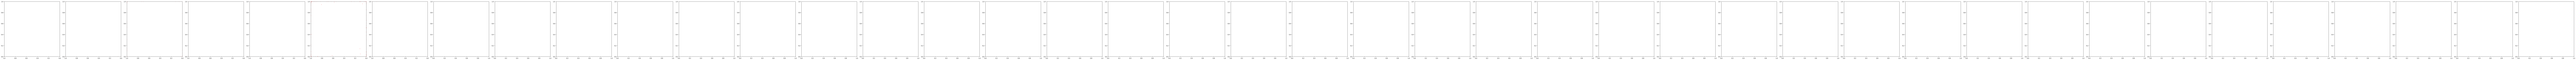

VRNN model weights saved for epoch 1 at vrnn_models\epoch_1.weights.h5.


Epoch 2/20: 100%|██████████| 253/253 [00:25<00:00,  9.95batch/s, Generator Loss=0.00845, Reconstruction Loss=0.00794, KL Loss=0.248]


Epoch 2: Generator Loss = 0.041389, Reconstruction Loss = 0.041122, KL Divergence Loss = 0.130246


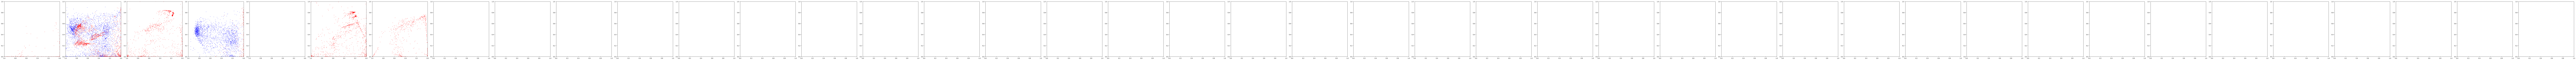

VRNN model weights saved for epoch 2 at vrnn_models\epoch_2.weights.h5.


Epoch 3/20: 100%|██████████| 253/253 [00:24<00:00, 10.16batch/s, Generator Loss=0.00398, Reconstruction Loss=0.00307, KL Loss=0.442]


Epoch 3: Generator Loss = 0.009473, Reconstruction Loss = 0.008750, KL Divergence Loss = 0.352909


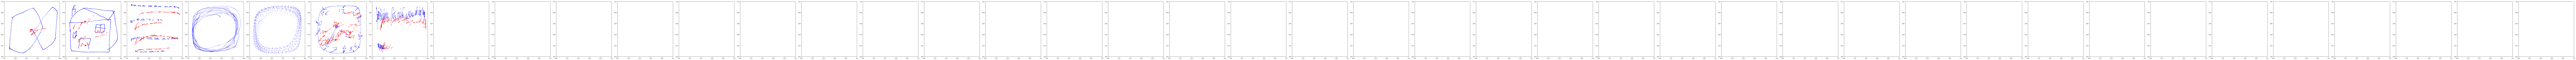

VRNN model weights saved for epoch 3 at vrnn_models\epoch_3.weights.h5.


Epoch 4/20: 100%|██████████| 253/253 [00:27<00:00,  9.09batch/s, Generator Loss=0.00345, Reconstruction Loss=0.00247, KL Loss=0.482]


Epoch 4: Generator Loss = 0.006522, Reconstruction Loss = 0.005612, KL Divergence Loss = 0.443846


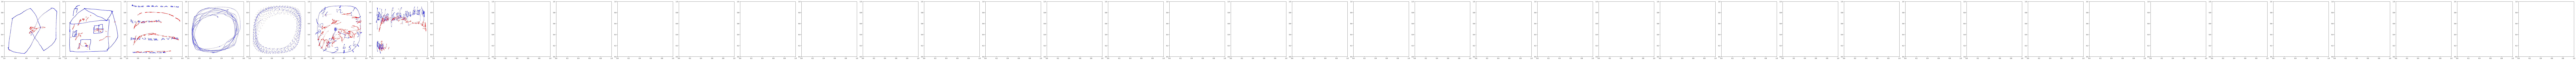

VRNN model weights saved for epoch 4 at vrnn_models\epoch_4.weights.h5.


Epoch 5/20: 100%|██████████| 253/253 [00:25<00:00, 10.00batch/s, Generator Loss=0.00371, Reconstruction Loss=0.00264, KL Loss=0.521]


Epoch 5: Generator Loss = 0.005168, Reconstruction Loss = 0.004219, KL Divergence Loss = 0.463078


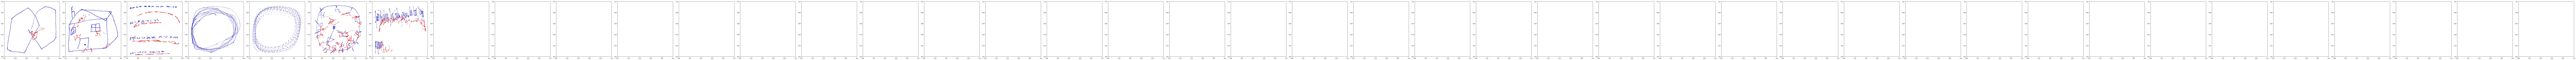

VRNN model weights saved for epoch 5 at vrnn_models\epoch_5.weights.h5.


Epoch 6/20: 100%|██████████| 253/253 [00:25<00:00,  9.98batch/s, Generator Loss=0.00251, Reconstruction Loss=0.00149, KL Loss=0.497] 


Epoch 6: Generator Loss = 0.003451, Reconstruction Loss = 0.002391, KL Divergence Loss = 0.516896


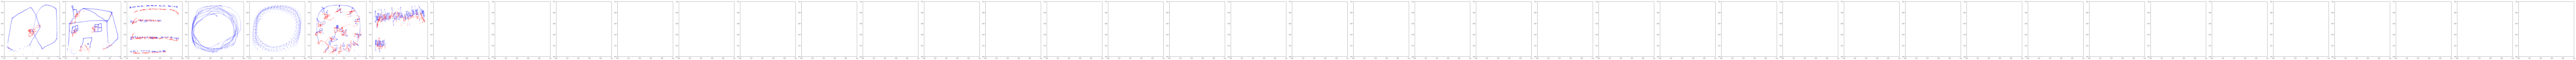

VRNN model weights saved for epoch 6 at vrnn_models\epoch_6.weights.h5.


Epoch 7/20: 100%|██████████| 253/253 [00:26<00:00,  9.62batch/s, Generator Loss=0.00228, Reconstruction Loss=0.00128, KL Loss=0.491] 


Epoch 7: Generator Loss = 0.002646, Reconstruction Loss = 0.001610, KL Divergence Loss = 0.505417


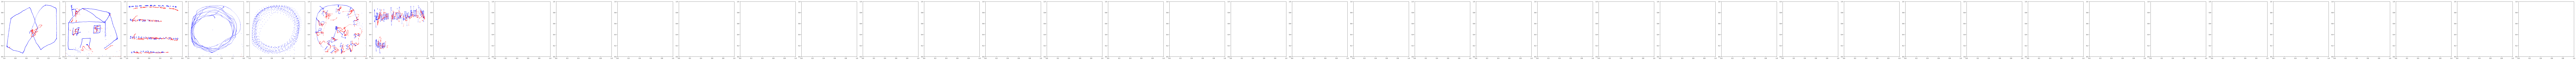

VRNN model weights saved for epoch 7 at vrnn_models\epoch_7.weights.h5.


Epoch 8/20: 100%|██████████| 253/253 [00:26<00:00,  9.68batch/s, Generator Loss=0.00189, Reconstruction Loss=0.000947, KL Loss=0.46] 


Epoch 8: Generator Loss = 0.002404, Reconstruction Loss = 0.001443, KL Divergence Loss = 0.468955


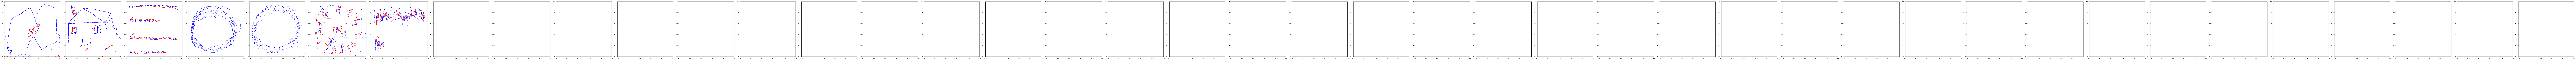

VRNN model weights saved for epoch 8 at vrnn_models\epoch_8.weights.h5.


Epoch 9/20: 100%|██████████| 253/253 [00:25<00:00,  9.78batch/s, Generator Loss=0.00176, Reconstruction Loss=0.000877, KL Loss=0.428]


Epoch 9: Generator Loss = 0.002201, Reconstruction Loss = 0.001294, KL Divergence Loss = 0.442577


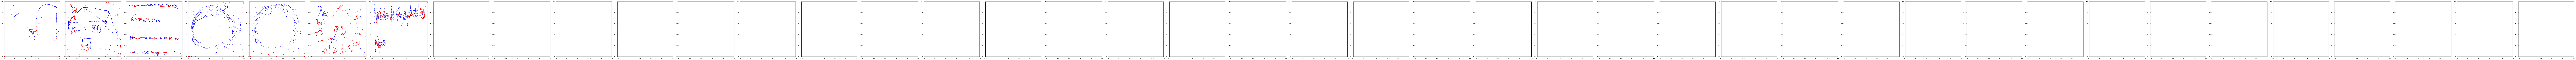

VRNN model weights saved for epoch 9 at vrnn_models\epoch_9.weights.h5.


Epoch 10/20: 100%|██████████| 253/253 [00:25<00:00,  9.75batch/s, Generator Loss=0.00185, Reconstruction Loss=0.00103, KL Loss=0.402] 


Epoch 10: Generator Loss = 0.002076, Reconstruction Loss = 0.001224, KL Divergence Loss = 0.415667


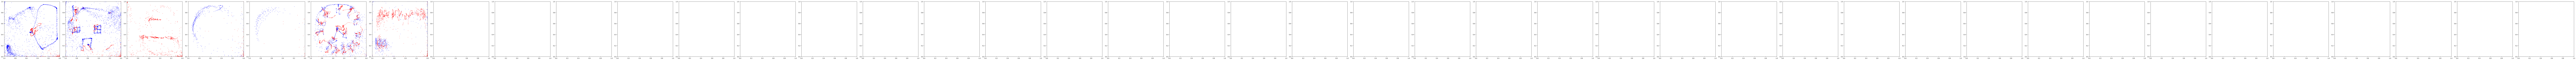

VRNN model weights saved for epoch 10 at vrnn_models\epoch_10.weights.h5.


Epoch 11/20: 100%|██████████| 253/253 [00:26<00:00,  9.40batch/s, Generator Loss=0.00164, Reconstruction Loss=0.000844, KL Loss=0.387]


Epoch 11: Generator Loss = 0.001969, Reconstruction Loss = 0.001161, KL Divergence Loss = 0.394335


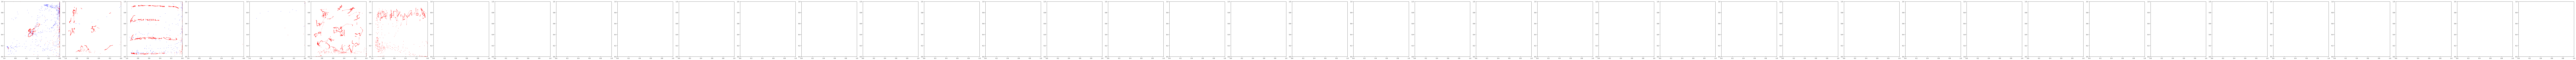

VRNN model weights saved for epoch 11 at vrnn_models\epoch_11.weights.h5.


Epoch 12/20: 100%|██████████| 253/253 [00:27<00:00,  9.26batch/s, Generator Loss=0.00171, Reconstruction Loss=0.000977, KL Loss=0.36] 


Epoch 12: Generator Loss = 0.001909, Reconstruction Loss = 0.001142, KL Divergence Loss = 0.374101


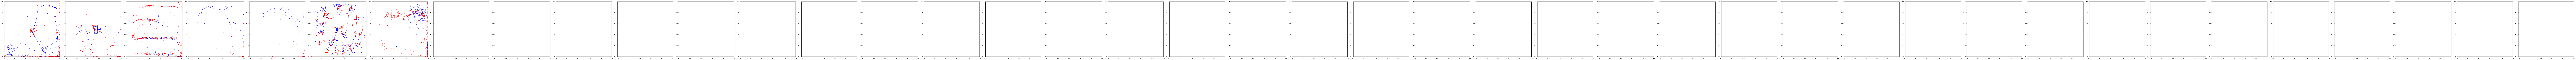

VRNN model weights saved for epoch 12 at vrnn_models\epoch_12.weights.h5.


Epoch 13/20: 100%|██████████| 253/253 [00:26<00:00,  9.43batch/s, Generator Loss=0.00164, Reconstruction Loss=0.000938, KL Loss=0.341]


Epoch 13: Generator Loss = 0.001795, Reconstruction Loss = 0.001057, KL Divergence Loss = 0.359860


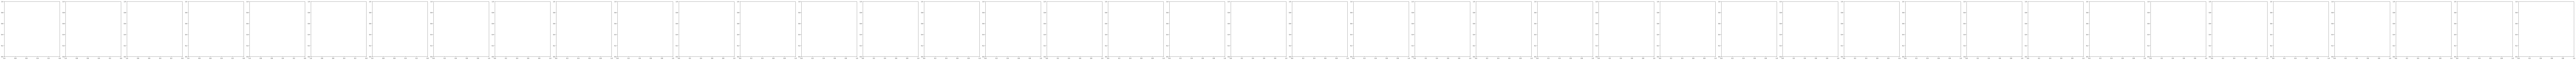

VRNN model weights saved for epoch 13 at vrnn_models\epoch_13.weights.h5.


Epoch 14/20: 100%|██████████| 253/253 [00:28<00:00,  8.94batch/s, Generator Loss=0.00169, Reconstruction Loss=0.00102, KL Loss=0.325] 


Epoch 14: Generator Loss = 0.001748, Reconstruction Loss = 0.001036, KL Divergence Loss = 0.347279


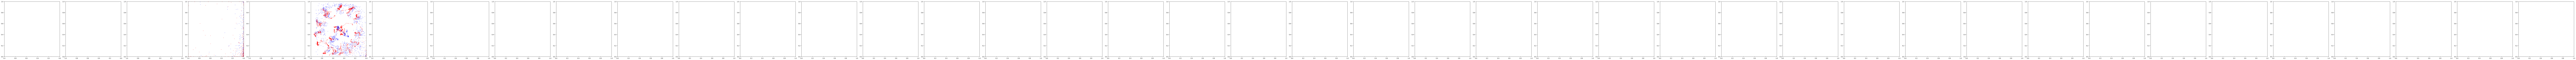

VRNN model weights saved for epoch 14 at vrnn_models\epoch_14.weights.h5.


Epoch 15/20: 100%|██████████| 253/253 [00:26<00:00,  9.71batch/s, Generator Loss=0.00128, Reconstruction Loss=0.000629, KL Loss=0.316]


Epoch 15: Generator Loss = 0.001543, Reconstruction Loss = 0.000855, KL Divergence Loss = 0.335555


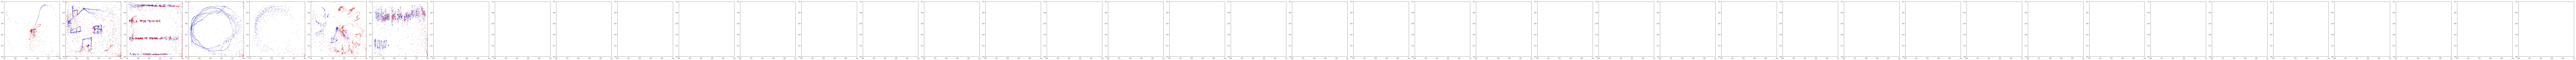

VRNN model weights saved for epoch 15 at vrnn_models\epoch_15.weights.h5.


Epoch 16/20: 100%|██████████| 253/253 [00:25<00:00,  9.96batch/s, Generator Loss=0.00282, Reconstruction Loss=0.00221, KL Loss=0.299] 


Epoch 16: Generator Loss = 0.001686, Reconstruction Loss = 0.001027, KL Divergence Loss = 0.321585


KeyboardInterrupt: 

In [63]:
#Cell 8
@tf.function
def train_vrnn_step(model, x, optimizer, birnn_discriminator=None):
    with tf.GradientTape() as tape:
        x_reconstructed, mean, logvar = model(x)
        reconstruction_loss, kl_loss, total_kl_loss = compute_loss(model, x)
        
        x = tf.cast(x, tf.float32)
        x_reconstructed = tf.cast(x_reconstructed, tf.float32)
        w_loss = model.wasserstein_loss(x, x_reconstructed) * 1e-6
        
        prior_means = tf.zeros_like(mean)
        prior_log_var = tf.zeros_like(logvar)
        kl_g_loss = tf.reduce_mean(model.kl_gauss(mean, prior_means, logvar, prior_log_var)) * 1e-6
        
        if birnn_discriminator is not None:
            real_predictions = birnn_discriminator(tf.expand_dims(x, axis=0))
            fake_predictions = birnn_discriminator(tf.expand_dims(x_reconstructed, axis=0))
            discriminator_loss = 0.001 * tf.reduce_mean(
                model.bce_loss(tf.ones_like(real_predictions), real_predictions) +
                model.bce_loss(tf.zeros_like(fake_predictions), fake_predictions)
            )
            generator_loss = reconstruction_loss + 0.000001 * total_kl_loss + discriminator_loss + w_loss + kl_g_loss
        else:
            generator_loss = reconstruction_loss + 0.000001 * total_kl_loss + w_loss + kl_g_loss
    
    gradients = tape.gradient(generator_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return generator_loss, reconstruction_loss, kl_loss

@tf.function
def train_birnn_step(birnn_model, real_data, generated_data, optimizer):
    with tf.GradientTape() as tape:
        real_predictions = birnn_model(real_data)
        generated_predictions = birnn_model(generated_data)
        real_loss = 0.01 * tf.keras.losses.binary_crossentropy(tf.ones_like(real_predictions), real_predictions)
        generated_loss = 0.01 * tf.keras.losses.binary_crossentropy(tf.zeros_like(generated_predictions), generated_predictions)
        total_loss = real_loss + generated_loss
    gradients = tape.gradient(total_loss, birnn_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, birnn_model.trainable_variables))
    return total_loss

# Initialize LSTM discriminator and optimizer
birnn_discriminator = BidirectionalDiscriminator()
birnn_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

batch_size = 512
train_datasets = [tf.data.Dataset.from_tensor_slices(data).shuffle(10000).batch(batch_size) for data in processed_data]

# Set up alternating epochs
vae_epochs = 60
birnn_interval = 10
epochs = 20
visual_per_num_epoch = 1
num_augmented_files = 7

generator_loss_history = []
reconstruction_loss_history = []
kl_loss_history = []
nrmse_history = []

save_dir = "vrnn_models"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

for epoch in range(epochs):
    generator_loss = 0 
    reconstruction_loss_sum = 0
    kl_loss_sum = 0
    num_batches = sum(len(dataset) for dataset in train_datasets)

    with tqdm(total=num_batches, desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
        for dataset in train_datasets:
            for batch in dataset:
                batch = tf.cast(batch, tf.float32)
                use_birnn = epoch >= vae_epochs and (epoch - vae_epochs) % birnn_interval == 0
                generator_loss_batch, reconstruction_loss, kl_loss = train_vrnn_step(
                    vrnn, batch, optimizer, birnn_discriminator if use_birnn else None
                )
                generator_loss += generator_loss_batch
                reconstruction_loss_sum += reconstruction_loss
                kl_loss_sum += kl_loss
                pbar.update(1)
                pbar.set_postfix({
                    'Generator Loss': float(generator_loss_batch), 
                    'Reconstruction Loss': float(reconstruction_loss), 
                    'KL Loss': float(kl_loss)
                })

    # BiRNN training section
    if epoch >= vae_epochs and (epoch - vae_epochs) % birnn_interval == 0:
        for data in processed_data:
            # Get initial hidden state for the decoder
            batch_size = data.shape[0]
            hidden_state = tf.zeros((batch_size, vrnn.hidden_dim))
            
            # Generate random latent vectors
            z = tf.random.normal(shape=(batch_size, vrnn.latent_dim))
            
            # Get RNN output for the hidden state
            data_tensor = tf.expand_dims(tf.cast(data, tf.float32), axis=1)
            rnn_output, _ = vrnn.rnn(data_tensor, initial_state=hidden_state)
            rnn_output = tf.squeeze(rnn_output, axis=1)
            
            # Generate fake data
            augmented_data = vrnn.decode(z, rnn_output).numpy()
            
            real_data = tf.expand_dims(data, axis=0)
            generated_data = tf.expand_dims(augmented_data, axis=0)
            birnn_loss = train_birnn_step(birnn_discriminator, real_data, generated_data, birnn_optimizer)
        
        print(f'BiRNN training at epoch {epoch+1}: Discriminator Loss = {birnn_loss.numpy()}')


    avg_generator_loss = generator_loss / num_batches  # Update the average calculation
    avg_reconstruction_loss = reconstruction_loss_sum / num_batches
    avg_kl_loss = kl_loss_sum / num_batches

    generator_loss_history.append(avg_generator_loss)  # Update history list
    reconstruction_loss_history.append(avg_reconstruction_loss)
    kl_loss_history.append(avg_kl_loss)



    print(f"Epoch {epoch+1}: Generator Loss = {avg_generator_loss:.6f}, Reconstruction Loss = {avg_reconstruction_loss:.6f}, KL Divergence Loss = {avg_kl_loss:.6f}")



    # Cell 5 (visualization part)
    if (epoch + 1) % visual_per_num_epoch == 0:
        base_latent_variability = 100.0
        latent_variability_range = (0.1, 5.0)

        augmented_datasets = generate_augmented_data_vrnn(vrnn, num_augmented_files, avg_data_points, processed_data, 
                                                     base_latent_variability, latent_variability_range)

        # Calculate actual latent variabilities and lengths used
        latent_variabilities = [base_latent_variability * np.random.uniform(latent_variability_range[0], latent_variability_range[1]) for _ in range(num_augmented_files)]
        augmented_lengths = [len(data) for data in augmented_datasets]

        fig, axs = plt.subplots(1, num_augmented_files + len(original_data_frames), figsize=(6*(num_augmented_files + len(original_data_frames)), 6))

        # for i, original_data in enumerate(original_data_frames):
        #     original_on_paper = original_data[original_data['pen_status'] == 1]
        #     original_in_air = original_data[original_data['pen_status'] == 0]

        #     axs[i].scatter(original_on_paper['y'], original_on_paper['x'], c='b', s=1, label='On Paper')
        #     axs[i].scatter(original_in_air['y'], original_in_air['x'], c='r', s=1, label='In Air')
        #     axs[i].set_title(f'Original Data {i+1}')
        #     axs[i].invert_xaxis()

        # Set consistent axis limits for square aspect ratio for both original and augmented data
        x_min = min(data[:, 0].min() for data in processed_data)
        x_max = max(data[:, 0].max() for data in processed_data)
        y_min = min(data[:, 1].min() for data in processed_data)
        y_max = max(data[:, 1].max() for data in processed_data)

        # for i, (augmented_data, latent_var, length) in enumerate(zip(augmented_datasets, latent_variabilities, augmented_lengths)):
        #     augmented_on_paper = augmented_data[augmented_data[:, 3] == 1]
        #     augmented_in_air = augmented_data[augmented_data[:, 3] == 0]

        #     axs[i+len(original_data_frames)].scatter(augmented_on_paper[:, 1], augmented_on_paper[:, 0], c='b', s=1, label='On Paper')
        #     axs[i+len(original_data_frames)].scatter(augmented_in_air[:, 1], augmented_in_air[:, 0], c='r', s=1, label='In Air')
        #     axs[i+len(original_data_frames)].invert_xaxis()
        #     axs[i+len(original_data_frames)].set_xlim(y_max, y_min)
        #     axs[i+len(original_data_frames)].set_ylim(x_min, x_max)

        for i, (augmented_data, latent_var, length) in enumerate(zip(augmented_datasets, latent_variabilities, augmented_lengths)):
            augmented_on_paper = augmented_data[augmented_data[:, 3] == 1]
            augmented_in_air = augmented_data[augmented_data[:, 3] == 0]

            axs[i].scatter(augmented_on_paper[:, 1], augmented_on_paper[:, 0], c='b', s=1, label='On Paper')
            axs[i].scatter(augmented_in_air[:, 1], augmented_in_air[:, 0], c='r', s=1, label='In Air')
            axs[i].invert_xaxis()
            axs[i].set_xlim(y_max, y_min)
            axs[i].set_ylim(x_min, x_max)


        plt.tight_layout()
        plt.show()
        def save_vrnn_model(model, epoch, save_dir="vrnn_models"):
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)
            
            # Save only the weights instead of the full model
            weights_save_path = os.path.join(save_dir, f"epoch_{epoch+1}.weights.h5")
            model.save_weights(weights_save_path)
            print(f"VRNN model weights saved for epoch {epoch+1} at {weights_save_path}.")

        save_vrnn_model(vrnn, epoch)
vrnn.save_weights('pentab_saved.weights.h5')
print("Final VAE model weights saved.")

# Final output and plots
plt.ioff()
plt.show()

vrnn.save('pentab_saved_model.h5')
print("Final VAE model saved.")

# Plot generator loss history
plt.figure(figsize=(10, 5))
plt.plot(generator_loss_history, label='Generator Loss')  # Update label
plt.plot(reconstruction_loss_history, label='Reconstruction Loss')
plt.plot(kl_loss_history, label='KL Divergence Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

plt.tight_layout()
plt.show()

In [12]:
# Cell 10
import shutil

# Base latent variability settings
base_latent_variability = 100.0
latent_variability_range = (0.99, 1.01)
all_augmented_data = []  # Global list to store all augmented data

def repeat_backwards(original_paa, augmented_length):
    repeat_count = augmented_length - len(original_paa)
    if repeat_count <= 0:
        return original_paa
    backwards_rows = np.empty((0, original_paa.shape[1]))
    for i in range(repeat_count):
        row_to_repeat = original_paa[-(i % len(original_paa) + 1)]
        backwards_rows = np.vstack((backwards_rows, row_to_repeat))
    return np.vstack((original_paa, backwards_rows))

def visualize_augmented_data_from_directory(directory):
    augmented_files = [f for f in os.listdir(directory) if f.startswith('synthetic_') and f.endswith('.svc')]
    num_files = len(augmented_files)
    if num_files == 0:
        print("No augmented data files found in the directory.")
        return
    
    fig, axs = plt.subplots(1, num_files, figsize=(6 * num_files, 6), constrained_layout=True)
    if num_files == 1:
        axs = [axs]
    
    for i, filename in enumerate(augmented_files):
        file_path = os.path.join(directory, filename)
        df = pd.read_csv(file_path, delim_whitespace=True, header=None)
        df.columns = ['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude']
        
        on_paper = df[df['pen_status'] == 1]
        in_air = df[df['pen_status'] == 0]

        axs[i].scatter(on_paper['y'], on_paper['x'], c='b', s=1, alpha=0.7, label='On Paper')
        axs[i].scatter(in_air['y'], in_air['x'], c='r', s=1, alpha=0.7, label='In Air')
        axs[i].set_title(f'Augmented Data {i + 1}')
        axs[i].set_xlabel('y')
        axs[i].set_ylabel('x')
        axs[i].invert_xaxis()
        axs[i].set_aspect('equal')
        axs[i].legend()
    
    plt.show()

def get_unique_filename(directory, filename):
    base, extension = os.path.splitext(filename)
    counter = 1
    while os.path.exists(os.path.join(directory, filename)):
        filename = f"{base}({counter}){extension}"
        counter += 1
    return filename

def download_augmented_data_with_modified_timestamp(augmented_datasets, scalers, original_data_frames, original_filenames, directory1='augmented_data', directory2='augmented_data_nested'):
    global all_augmented_data  # Access the global list

    if not os.path.exists(directory1):
        os.makedirs(directory1)
    
    if not os.path.exists(directory2):
        os.makedirs(directory2)

    for i, (augmented_data, scaler, original_df, original_filename) in enumerate(zip(augmented_datasets, scalers, original_data_frames, original_filenames)):
        augmented_xyz = scaler.inverse_transform(augmented_data[:, :3])
        augmented_xyz_int = np.rint(augmented_xyz).astype(int)
        pen_status = augmented_data[:, 3].astype(int)
        original_paa = original_df[['pressure', 'azimuth', 'altitude']].values
        
        if len(augmented_data) > len(original_paa):
            original_paa = repeat_backwards(original_paa, len(augmented_data))
        
        original_paa_int = np.rint(original_paa).astype(int)
        
        new_timestamps = np.zeros(len(augmented_data), dtype=int)
        increment_sequence = [7, 8]
        current_time = 0
        for idx in range(len(augmented_data)):
            new_timestamps[idx] = current_time
            current_time += increment_sequence[idx % 2]

        augmented_xyz_int[:, 2] = new_timestamps

        augmented_data_original_scale = np.column_stack((
            augmented_xyz_int,
            pen_status,
            original_paa_int[:len(augmented_data)]
        ))

        nested_filename = original_filename
        nested_file_path = os.path.join(directory2, nested_filename)

        augmented_filename = f"synthetic_{original_filename}"
        augmented_filename = get_unique_filename(directory1, augmented_filename)
        augmented_file_path = os.path.join(directory1, augmented_filename)

        np.savetxt(augmented_file_path, augmented_data_original_scale, fmt='%d', delimiter=' ')
        np.savetxt(nested_file_path, augmented_data_original_scale, fmt='%d', delimiter=' ')

        all_augmented_data.append(augmented_data_original_scale)

        print(f"Augmented data saved to {augmented_file_path}")
        print(f"Augmented data saved to {nested_file_path}")
        print(f"Shape of augmented data for {original_filename}: {augmented_data_original_scale.shape}")

def nested_augmentation(model_path, num_augmentations, num_files_to_use):
    """
    Perform nested augmentation using a specified model file.
    
    Args:
        model_path (str): Path to the model weights file
        num_augmentations (int): Number of augmentation iterations
        num_files_to_use (int): Number of files to process in each iteration
    """
    # Initialize a new VRNN model with the same architecture
    vrnn_model = VRNN(
        latent_dim=2048,
        hidden_dim=128,
        sequence_length=1
    )
    
    # Build the model properly with a dummy input
    dummy_batch = tf.zeros((1, 4))
    _ = vrnn_model(dummy_batch)
    
    try:
        # Load the specified model weights
        if os.path.exists(model_path):
            print(f"Loading weights from: {model_path}")
            vrnn_model.load_weights(model_path)
            print("Model weights loaded successfully.")
        else:
            print(f"Model file not found at: {model_path}")
            return
    except Exception as e:
        print(f"Error loading model weights: {str(e)}")
        return
    
    global data_frames, processed_data, scalers, avg_data_points, input_filenames, original_data_frames

    for iteration in range(num_augmentations):
        print(f"Starting augmentation iteration {iteration + 1}")
        
        if iteration > 0:
            directory = 'augmented_data_nested'
            try:
                data_frames, processed_data, scalers, avg_data_points, input_filenames, original_data_frames = upload_and_process_files(directory, num_files_to_use)
            except Exception as e:
                print(f"Error processing files in iteration {iteration + 1}: {str(e)}")
                continue
        
        try:
            augmented_datasets = generate_augmented_data_vrnn(
                vrnn_model, 
                num_files_to_use, 
                avg_data_points, 
                processed_data, 
                base_latent_variability, 
                latent_variability_range
            )
        
            if os.path.exists('augmented_data_nested'):
                shutil.rmtree('augmented_data_nested')
            os.makedirs('augmented_data_nested')
        
            download_augmented_data_with_modified_timestamp(
                augmented_datasets, 
                scalers, 
                original_data_frames, 
                input_filenames
            )
        
            print(f"Completed augmentation iteration {iteration + 1}")
        except Exception as e:
            print(f"Error in augmentation iteration {iteration + 1}: {str(e)}")
            continue
    
    if os.path.exists('augmented_data_nested'):
        shutil.rmtree('augmented_data_nested')
        print("Cleared augmented_data_nested directory after the final iteration.")
    
    print("Nested augmentation process completed.")
    visualize_augmented_data_from_directory('augmented_data')

# Example usage:
# Specify the path to your model weights file
model_path = "final_vrnn_models/vrnn.weights.h5"  
num_augmentations = 1  # Number of nested augmentations

# Run the nested augmentation process
nested_augmentation(model_path, num_augmentations, num_files_to_use)


Loading weights from: final_vrnn_models/vrnn.weights.h5
Model weights loaded successfully.
Starting augmentation iteration 1
Augmented data saved to augmented_data\synthetic_u00001s00001_hw00001.svc
Augmented data saved to augmented_data_nested\u00001s00001_hw00001.svc
Shape of augmented data for u00001s00001_hw00001.svc: (3444, 7)
Augmented data saved to augmented_data\synthetic_u00001s00001_hw00002.svc
Augmented data saved to augmented_data_nested\u00001s00001_hw00002.svc
Shape of augmented data for u00001s00001_hw00002.svc: (5553, 7)
Augmented data saved to augmented_data\synthetic_u00001s00001_hw00004.svc
Augmented data saved to augmented_data_nested\u00001s00001_hw00004.svc
Shape of augmented data for u00001s00001_hw00004.svc: (2315, 7)
Augmented data saved to augmented_data\synthetic_u00001s00001_hw00005.svc
Augmented data saved to augmented_data_nested\u00001s00001_hw00005.svc
Shape of augmented data for u00001s00001_hw00005.svc: (1531, 7)
Augmented data saved to augmented_data\

C:\Users\annek\AppData\Local\Temp\ipykernel_9012\1832516494.py:32: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
C:\Users\annek\AppData\Local\Temp\ipykernel_9012\1832516494.py:32: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
C:\Users\annek\AppData\Local\Temp\ipykernel_9012\1832516494.py:32: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
C:\Users\annek\AppData\Local\Temp\ipykernel_9012\1832516494.py:32: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future v

ValueError: Image size of 302400x600 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 302400x600 with 504 Axes>

In [ ]:
# Cell 11 NRMSE
from glob import glob
import re

def read_svc_file(file_path):
    return pd.read_csv(file_path, sep=' ', header=None, 
                       names=['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude'])

def calculate_nrmse(original, predicted):
    if original.shape != predicted.shape:
        raise ValueError("The shapes of the original and predicted datasets must match.")
    mse = np.mean((original - predicted) ** 2)
    rmse = np.sqrt(mse)
    nrmse = rmse / (np.max(original) - np.min(original))
    return nrmse

def get_matching_augmented_files(original_file, augmented_folder):
    base_name = os.path.basename(original_file)
    base_name_without_ext = os.path.splitext(base_name)[0]
    pattern = os.path.join(augmented_folder, f"synthetic_{base_name_without_ext}*.svc")
    matching_files = glob(pattern)
    
    # Sort files based on the number in parentheses, with the base file (no number) first
    def sort_key(filename):
        match = re.search(r'\((\d+)\)', filename)
        return int(match.group(1)) if match else -1
    
    return sorted(matching_files, key=sort_key)

def process_files(original_folder, augmented_folder, input_filenames):
    nrmse_results = {}

    # Create a set of base filenames (without extensions) for easy comparison
    input_filenames_set = {os.path.splitext(os.path.basename(filename))[0] for filename in input_filenames}

    for original_file in glob(os.path.join(original_folder, "*.svc")):
        base_name = os.path.splitext(os.path.basename(original_file))[0]
        
        # Only process files that are present in input_filenames
        if base_name not in input_filenames_set:
            continue
        
        file_name = os.path.basename(original_file)
        original_data = read_svc_file(original_file)
        
        matching_augmented_files = get_matching_augmented_files(original_file, augmented_folder)
        
        file_nrmse = []
        for augmented_file in matching_augmented_files:
            augmented_data = read_svc_file(augmented_file)
            
            # Trim to the shorter length
            min_length = min(len(original_data), len(augmented_data))
            original_array = original_data.iloc[:min_length].values
            augmented_array = augmented_data.iloc[:min_length].values
            
            nrmse = calculate_nrmse(original_array, augmented_array)
            file_nrmse.append(nrmse)
        
        nrmse_results[file_name] = file_nrmse

    return nrmse_results

# Define the folders directly in the notebook cell
original_folder = "original_absolute"
augmented_folder = "all_augmented_data"

# Process the files and calculate NRMSE
results = process_files(original_folder, augmented_folder, input_filenames)

# Display the results
for original_file, nrmse_values in results.items():
    print(f"Results for {original_file}:")
    for i, nrmse in enumerate(nrmse_values):
        augmented_version = f"({i})" if i > 0 else "base"
        print(f"  NRMSE for augmented version {augmented_version}: {nrmse:.4f}")
    
    if nrmse_values:
        avg_nrmse = np.mean(nrmse_values)
        print(f"  Average NRMSE: {avg_nrmse:.4f}")
    print()

# Calculate and display the overall average NRMSE
all_nrmse = [nrmse for nrmse_list in results.values() for nrmse in nrmse_list]
overall_avg_nrmse = np.mean(all_nrmse)
print(f"Overall Average NRMSE: {overall_avg_nrmse:.4f}")

Results for u00001s00001_hw00003.svc:
  NRMSE for augmented version base: 0.0000
  Average NRMSE: 0.0000

Results for u00002s00001_hw00003.svc:
  NRMSE for augmented version base: 0.0000
  Average NRMSE: 0.0000

Results for u00003s00001_hw00003.svc:
  NRMSE for augmented version base: 0.0000
  Average NRMSE: 0.0000

Results for u00004s00001_hw00003.svc:
  NRMSE for augmented version base: 0.0000
  Average NRMSE: 0.0000

Results for u00005s00001_hw00003.svc:
  NRMSE for augmented version base: 0.0000
  Average NRMSE: 0.0000

Results for u00006s00001_hw00003.svc:
  NRMSE for augmented version base: 0.0000
  Average NRMSE: 0.0000

Results for u00007s00001_hw00003.svc:
  NRMSE for augmented version base: 0.0000
  Average NRMSE: 0.0000

Results for u00008s00001_hw00003.svc:
  NRMSE for augmented version base: 0.0000
  Average NRMSE: 0.0000

Results for u00009s00001_hw00003.svc:
  NRMSE for augmented version base: 0.0000
  Average NRMSE: 0.0000

Results for u00010s00001_hw00003.svc:
  NRMSE 

In [35]:
# Cell 12 Post-Hoc Discriminative Score
def process_files(original_folder, augmented_folder, input_filenames):
    all_real_data = []
    all_synthetic_data = []

    # Create a set of base filenames (without extensions) for easy comparison
    input_filenames_set = {os.path.splitext(os.path.basename(filename))[0] for filename in input_filenames}

    for original_file in glob(os.path.join(original_folder, "*.svc")):
        base_name = os.path.splitext(os.path.basename(original_file))[0]
        
        # Only process files that are present in input_filenames
        if base_name not in input_filenames_set:
            continue
        
        original_data = read_svc_file(original_file)
        all_real_data.append(original_data.values)
        
        matching_augmented_files = get_matching_augmented_files(original_file, augmented_folder)
        
        for augmented_file in matching_augmented_files:
            augmented_data = read_svc_file(augmented_file)
            all_synthetic_data.append(augmented_data.values)

    return np.concatenate(all_real_data), np.concatenate(all_synthetic_data)

def create_lstm_classifier(input_shape):
    model = Sequential([
        LSTM(64, input_shape=input_shape, return_sequences=True),
        LSTM(32),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def prepare_data_for_lstm(real_data, synthetic_data):
    n_features = min(real_data.shape[1], synthetic_data.shape[1])
    real_data_trimmed = real_data[:, :n_features]
    synthetic_data_trimmed = synthetic_data[:, :n_features]
    
    X = np.vstack((real_data_trimmed, synthetic_data_trimmed))
    y = np.concatenate((np.ones(len(real_data)), np.zeros(len(synthetic_data))))
    return X, y

def post_hoc_discriminative_score(real_data, synthetic_data, n_splits=10):
    X, y = prepare_data_for_lstm(real_data, synthetic_data)
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []
    
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"\nFold {fold + 1}/{n_splits}:")  # New print statement for fold numbers
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
        X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

        model = create_lstm_classifier((1, X_train.shape[2]))
        
        # Train model and show epoch progress for this fold
        history = model.fit(X_train, y_train, epochs=2, batch_size=512, verbose=1)

        y_pred = (model.predict(X_test) > 0.5).astype(int)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)
    return mean_accuracy, std_accuracy

# Specify your folders
original_folder = "original_absolute"
augmented_folder = "try"

# Process files, without NRMSE
real_data, synthetic_data = process_files(original_folder, augmented_folder, input_filenames)

# Compute post-hoc discriminative score
mean_accuracy, std_accuracy = post_hoc_discriminative_score(real_data, synthetic_data)

print(f"Mean accuracy: {mean_accuracy:.4f} (±{std_accuracy:.4f})")


Fold 1/10:


C:\Users\annek\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2


KeyboardInterrupt: 

In [12]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from glob import glob
import os
import time

def read_svc_file(file_path):
    """Read an SVC file and return its contents as a DataFrame."""
    try:
        df = pd.read_csv(file_path, sep=' ', header=None)
        if df.empty:
            print(f"Warning: Empty file found: {file_path}")
            return None
        return df
    except Exception as e:
        print(f"Error reading file {file_path}: {str(e)}")
        return None

def get_matching_augmented_file(original_file, augmented_folder):
    """Get matching augmented file for a given original file."""
    base_name = os.path.splitext(os.path.basename(original_file))[0]
    augmented_file = os.path.join(augmented_folder, f"synthetic_{base_name}.svc")
    if not os.path.exists(augmented_file):
        print(f"Warning: No matching augmented file found for {base_name}")
        return None
    return augmented_file

def process_files(original_folder, augmented_folder):
    """Process original and augmented files and prepare them for analysis."""
    paired_data = []  # Store paired original and synthetic data

    for original_file in glob(os.path.join(original_folder, "*.svc")):
        augmented_file = get_matching_augmented_file(original_file, augmented_folder)
        if augmented_file is None:
            continue
            
        original_data = read_svc_file(original_file)
        augmented_data = read_svc_file(augmented_file)
        
        if (original_data is not None and augmented_data is not None and 
            original_data.shape[1] == augmented_data.shape[1]):
            paired_data.append((original_file, augmented_file))

    if not paired_data:
        raise ValueError("No valid data pairs found for processing")
        
    print(f"Successfully processed {len(paired_data)} pairs of files")
    return paired_data

def prepare_sequences(data, time_steps=4):
    """Prepare sequences for prediction, using all but last timestep as input."""
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps - 1].flatten())  # Flatten for XGBoost
        y.append(data[i + time_steps - 1])
    return np.array(X), np.array(y)

def evaluate_synthetic_data(original_file, synthetic_file, n_experiments=10):
    """Evaluate a single synthetic dataset against its original counterpart."""
    print(f"\nProcessing files: {os.path.basename(original_file)} and {os.path.basename(synthetic_file)}")

    original_df = read_svc_file(original_file)
    synthetic_df = read_svc_file(synthetic_file)

    if original_df is None or synthetic_df is None:
        return None

    # Define columns that should be integers (based on your data)
    integer_columns = [0, 1, 4, 5]  # Columns 1, 2, 5, and 6 (0-based indexing)

    scaler = MinMaxScaler()
    original_scaled = scaler.fit_transform(original_df)
    synthetic_scaled = scaler.transform(synthetic_df)

    experiment_mapes = []

    for experiment in range(n_experiments):
        print(f"Experiment {experiment+1}/{n_experiments} - Running...")
        start_time = time.time()

        X_train, y_train = prepare_sequences(synthetic_scaled)
        X_test, y_test = prepare_sequences(original_scaled)

        if len(X_train) == 0 or len(X_test) == 0:
            print("Warning: No valid sequences prepared for training or testing.")
            continue

        mapes_per_dim = []
        for dim in range(y_train.shape[1]):
            model = XGBRegressor(
                n_estimators=100,
                learning_rate=0.1,
                max_depth=6,
                random_state=experiment + 42
            )

            model.fit(X_train, y_train[:, dim], verbose=False)
            y_pred = model.predict(X_test)

            # Inverse transform back to original scale
            y_true_original = original_df.iloc[len(original_df)-len(y_test):, dim].values

            temp_data = np.zeros((len(y_pred), original_df.shape[1]))
            temp_data[:, dim] = y_pred
            y_pred_original = scaler.inverse_transform(temp_data)[:, dim]

            # Round predictions for integer columns
            if dim in integer_columns:
                y_pred_original = np.round(y_pred_original)

            # Special rounding for dimension 4 (index 3), to 1 or 0
            if dim == 3:
                y_pred_original = np.round(y_pred_original)

            # Remove decimals before calculating MAPE
            y_pred_original = np.round(y_pred_original).astype(int)
            y_true_original = np.round(y_true_original).astype(int)

            # Custom MAPE calculation with proper handling of zeros and small values
            errors = []
            for true, pred in zip(y_true_original, y_pred_original):
                if true == 0:
                    if pred == 0:
                        errors.append(0)  # Both true and predicted are zero
                    else:
                        errors.append(100)  # Predicted non-zero for true zero
                else:
                    error = abs((true - pred) / true) * 100
                    errors.append(min(error, 100))  # Cap error at 100%

            mape = np.mean(errors)
            mapes_per_dim.append(mape)

        experiment_mapes.append(np.mean(mapes_per_dim))
        elapsed_time = time.time() - start_time
        print(f"  Experiment {experiment+1} completed in {elapsed_time:.1f}s. Avg MAPE: {np.mean(mapes_per_dim):.2f}%")

    if experiment_mapes:
        return np.mean(experiment_mapes), np.std(experiment_mapes)
    return None

def post_hoc_predictive_score(original_folder, augmented_folder):
    """Calculate post-hoc predictive score for all pairs of original and synthetic data."""
    try:
        print("\nInitializing post-hoc predictive score calculation...")
        paired_files = process_files(original_folder, augmented_folder)
        
        all_results = []
        
        for original_file, synthetic_file in paired_files:
            result = evaluate_synthetic_data(original_file, synthetic_file)
            if result is not None:
                mean_mape, std_mape = result
                all_results.append((mean_mape, std_mape))
                
                print(f"\nResults for {os.path.basename(synthetic_file)}:")
                print(f"Mean MAPE: {mean_mape:.2f}%")
                print(f"Std MAPE: {std_mape:.2f}%")
        
        if not all_results:
            raise ValueError("No valid results calculated")
        
        overall_mean = np.mean([r[0] for r in all_results])
        overall_std = np.mean([r[1] for r in all_results])
        
        print("\nOverall Results:")
        print(f"Overall Mean MAPE: {overall_mean:.2f}%")
        print(f"Overall Mean Std MAPE: {overall_std:.2f}%")
        
        return overall_mean, overall_std
        
    except Exception as e:
        print(f"Error in post-hoc predictive score calculation: {str(e)}")
        return None, None

def main():
    try:
        original_folder = "original_absolute"
        augmented_folder = "try"
        
        print("Starting post-hoc predictive score calculation...")
        mean_mape, std_mape = post_hoc_predictive_score(original_folder, augmented_folder)
        
        if mean_mape is not None and std_mape is not None:
            print("\nFinal Results:")
            print(f"Mean MAPE: {mean_mape:.2f}%")
            print(f"Standard Deviation of MAPE: {std_mape:.2f}%")
        else:
            print("Failed to calculate post-hoc predictive score")
            
    except Exception as e:
        print(f"Error in main execution: {str(e)}")

if __name__ == "__main__":
    main()


Starting post-hoc predictive score calculation...

Initializing post-hoc predictive score calculation...
Successfully processed 10 pairs of files

Processing files: u00001s00001_hw00003.svc and synthetic_u00001s00001_hw00003.svc
Experiment 1/10 - Running...
  Experiment 1 completed in 5.5s. Avg MAPE: 10.12%
Experiment 2/10 - Running...
  Experiment 2 completed in 4.5s. Avg MAPE: 10.12%
Experiment 3/10 - Running...
  Experiment 3 completed in 4.1s. Avg MAPE: 10.12%
Experiment 4/10 - Running...


KeyboardInterrupt: 

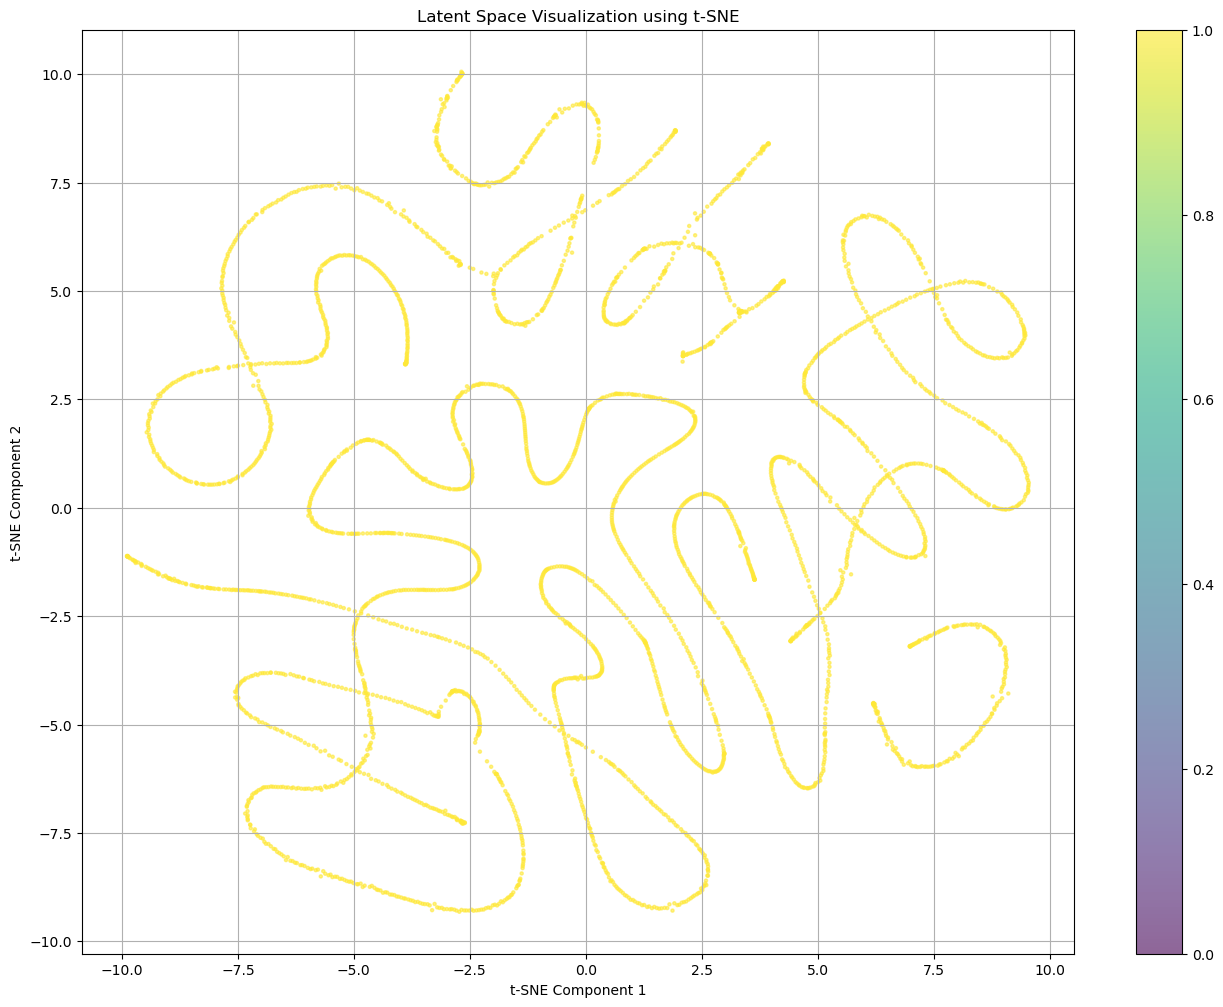

In [ ]:
#Cell 13 Function to visualize the latent space with a color gradient
from sklearn.manifold import TSNE

def visualize_latent_space(model, data, perplexity=5, learning_rate=200, n_iter=250):
    # Encode data into the latent space
    latent_means, _ = model.encode(tf.convert_to_tensor(data, dtype=tf.float32))
    latent_means_np = latent_means.numpy()
    
    # Use t-SNE to reduce dimensionality to 2D
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter)
    latent_2d = tsne.fit_transform(latent_means_np)
    
    # Create a color map for the latent points
    norm = plt.Normalize(vmin=np.min(latent_means_np), vmax=np.max(latent_means_np))
    cmap = plt.cm.cividis  # You can change the colormap to 'plasma', 'inferno', etc.
    colors = cmap(norm(latent_means_np).sum(axis=1))  # Coloring based on the sum of latent variables
    
    # Plot the 2D t-SNE result with the color map
    plt.figure(figsize=(16, 12))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=colors, s=5, alpha=0.6)
    plt.colorbar(scatter)  # Add a color bar for the gradient
    plt.title('Latent Space Visualization using t-SNE')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.grid(True)
    plt.show()

# Visualize latent space for one of the processed datasets
visualize_latent_space(vae, processed_data[0])

In [ ]:
# Cell 9 (modified to retain augmented data length)
def download_augmented_data_with_modified_timestamp(augmented_datasets, scalers, original_data_frames, original_filenames, directory='augmented_data'):
    if not os.path.exists(directory):
        os.makedirs(directory)

    for i, (augmented_data, scaler, original_df, original_filename) in enumerate(zip(augmented_datasets, scalers, original_data_frames, original_filenames)):
        # Inverse transform the augmented data
        augmented_xyz = scaler.inverse_transform(augmented_data[:, :3])
        
        # Round to integers
        augmented_xyz_int = np.rint(augmented_xyz).astype(int)
        
        # Get pen status from augmented data
        pen_status = augmented_data[:, 3].astype(int)
        
        # Prepare pressure, azimuth, altitude data
        original_paa = original_df[['pressure', 'azimuth', 'altitude']].values
        
        if len(augmented_data) > len(original_paa):
            original_paa = repeat_backwards(original_paa, len(augmented_data))
        
        # Round pressure, azimuth, altitude to integers
        original_paa_int = np.rint(original_paa).astype(int)
        
        # Generate new timestamps: start at 0, alternately incrementing by 7 and 8
        new_timestamps = np.zeros(len(augmented_data), dtype=int)
        increment_sequence = [7, 8]
        current_time = 0
        for idx in range(len(augmented_data)):
            new_timestamps[idx] = current_time
            current_time += increment_sequence[idx % 2]  # Alternate between 7 and 8

        # Replace the timestamp in the 3rd column of augmented_xyz_int
        augmented_xyz_int[:, 2] = new_timestamps

        # Combine all data: XYZ, pen status, pressure, azimuth, altitude
        augmented_data_original_scale = np.column_stack((
            augmented_xyz_int,
            pen_status,
            original_paa_int[:len(augmented_data)]
        ))

        # Construct the new file name to match the original file name
        augmented_filename = f"augmented_{original_filename}"
        augmented_file_path = os.path.join(directory, augmented_filename)

        # Save the augmented data to a file
        np.savetxt(augmented_file_path, augmented_data_original_scale, fmt='%d', delimiter=' ')

        print(f"Augmented data saved to {augmented_file_path}")
        print(f"Shape of augmented data for {original_filename}: {augmented_data_original_scale.shape}")

# Example call to the function
download_augmented_data_with_modified_timestamp(augmented_datasets, scalers, original_data_frames, input_filenames)

# Add this diagnostic print statement after generating augmented_datasets
print("Shapes of augmented datasets:")
for i, aug_data in enumerate(augmented_datasets):
    print(f"Shape of augmented dataset {i+1}: {aug_data.shape}")
